# Cellpose

github: https://github.com/mouseland/cellpose <br>
data: http://www.cellpose.org/dataset <br>
paper: http://www.cellpose.org/dataset <br>

In [27]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import cellpose
from cellpose import utils, io, models, plot
import os, sys
import glob
import cv2
from shapely.geometry import Polygon
import torch
import importlib
importlib.reload(models)

currentdir = os.path.dirname(os.path.realpath('run_cellpose.ipynb'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

In [28]:
img_f2c =plt.imread('../data/fit_to_circle/test/cropped_P201_IMG_20151029_162934.png')
plt.imshow(img_f2c)
plt.axis('off')
plt.show()
masks_f2c =plt.imread('../data/fit_to_circle/test/cropped_P201_IMG_20151029_162934_masks.png')
plt.imshow(masks_f2c)
plt.axis('off')
plt.show()

In [29]:
len(np.unique(masks_f2c))

278

In [30]:
# org_files = ['../data/testing_openflexure/2021-03-05_15-50-16_0_0_5578.jpeg', 
#             '../data/fit_to_circle/cropped_P201_IMG_20151029_162934.png',
#             '../data/fit_to_circle/cropped_P206_IMG_20151112_164625.png',
#             ]

org_files = ['../data/fit_to_circle/test/cropped_P3_IMG_20150621_112138.png',
            '../data/fit_to_circle/train/cropped_P206_IMG_20151112_164625.png', 
            '../data/fit_to_circle/test/cropped_P201_IMG_20151029_162934.png',
            '../data/fit_to_circle/train/cropped_P50_IMG_20150820_162504.png'
            ]

# view 1 image
img = io.imread(org_files[-1])
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

In [31]:
def mask_rgb(masks, colors=None):
    """ masks in random rgb colors
    Parameters
    ----------------
    masks: int, 2D array
        masks where 0=NO masks; 1,2,...=mask labels
    colors: int, 2D array (optional, default None)
        size [nmasks x 3], each entry is a color in 0-255 range
    Returns
    ----------------
    RGB: uint8, 3D array
        array of masks overlaid on grayscale image
    """
    if colors is not None:
        if colors.max()>1:
            colors = np.float32(colors)
            colors /= 255
        colors = utils.rgb_to_hsv(colors)
    
    HSV = np.zeros((masks.shape[0], masks.shape[1], 3), np.float32)
    HSV[:,:,2] = 1.0
    for n in range(int(masks.max())):
        ipix = (masks==n+1).nonzero()
        if colors is None:
            HSV[ipix[0],ipix[1],0] = np.random.rand()
        else:
            HSV[ipix[0],ipix[1],0] = colors[n,0]
        HSV[ipix[0],ipix[1],1] = np.random.rand()*0.5+0.5
        HSV[ipix[0],ipix[1],2] = np.random.rand()*0.5+0.5
    RGB = (utils.hsv_to_rgb(HSV) * 255).astype(np.uint8)
    return RGB

def mask_overlay(img, masks, colors=None):
    """ overlay masks on image (set image to grayscale)
    Parameters
    ----------------
    img: int or float, 2D or 3D array
        img is of size [Ly x Lx (x nchan)]
    masks: int, 2D array
        masks where 0=NO masks; 1,2,...=mask labels
    colors: int, 2D array (optional, default None)
        size [nmasks x 3], each entry is a color in 0-255 range
    Returns
    ----------------
    RGB: uint8, 3D array
        array of masks overlaid on grayscale image
    """
    if colors is not None:
        if colors.max()>1:
            colors = np.float32(colors)
            colors /= 255
        colors = utils.rgb_to_hsv(colors)
    if img.ndim>2:
        img = img.astype(np.float32).mean(axis=-1)
    else:
        img = img.astype(np.float32)
    img = utils.normalize99(img)
    img -= img.min()
    img /= img.max()
    HSV = np.zeros((img.shape[0], img.shape[1], 3), np.float32)
    HSV[:,:,2] = np.clip(img*1.5, 0, 1.0)
    for n in range(int(masks.max())):
        ipix = (masks==n+1).nonzero()
        if colors is None:
            HSV[ipix[0],ipix[1],0] = np.random.rand()
        else:
            HSV[ipix[0],ipix[1],0] = colors[n,0]
        HSV[ipix[0],ipix[1],1] = 1.0
    RGB = (utils.hsv_to_rgb(HSV) * 255).astype(np.uint8)
    return RGB

def image_to_rgb(img0, channels=[0,0]):
    """ image is 2 x Ly x Lx or Ly x Lx x 2 - change to RGB Ly x Lx x 3 """
    img = img0.copy()
    img = img.astype(np.float32)
    if img.ndim<3:
        img = img[:,:,np.newaxis]
    if img.shape[0]<5:
        img = np.transpose(img, (1,2,0))
    if channels[0]==0:
        img = img.mean(axis=-1)[:,:,np.newaxis]
    for i in range(img.shape[-1]):
        if np.ptp(img[:,:,i])>0:
            img[:,:,i] = utils.normalize99(img[:,:,i])
            img[:,:,i] = np.clip(img[:,:,i], 0, 1)
    img *= 255
    img = np.uint8(img)
    RGB = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
    if img.shape[-1]==1:
        RGB = np.tile(img,(1,1,3))
    else:
        RGB[:,:,channels[0]-1] = img[:,:,0]
        if channels[1] > 0:
            RGB[:,:,channels[1]-1] = img[:,:,1]
    return RGB

def interesting_patch(mask, bsize=130):
    """ get patch of size bsize x bsize with most masks """
    Ly,Lx = mask.shape
    m = np.float32(mask>0)
    m = gaussian_filter(m, bsize/2)
    y,x = np.unravel_index(np.argmax(m), m.shape)
    ycent = max(bsize//2, min(y, Ly-bsize//2))
    xcent = max(bsize//2, min(x, Lx-bsize//2))
    patch = [np.arange(ycent-bsize//2, ycent+bsize//2, 1, int),
             np.arange(xcent-bsize//2, xcent+bsize//2, 1, int)]
    return patch

def disk(med, r, Ly, Lx):
    """ returns pixels of disk with radius r and center med """
    yy, xx = np.meshgrid(np.arange(0,Ly,1,int), np.arange(0,Lx,1,int),
                         indexing='ij')
    inds = ((yy-med[0])**2 + (xx-med[1])**2)**0.5 <= r
    y = yy[inds].flatten()
    x = xx[inds].flatten()
    return y,x

In [32]:
imgs = [cv2.imread(img_path) for img_path in org_files]

In [33]:
img_height = 1024
img_width = 1024
img_channels = 3
imgs_red = np.zeros((len(imgs), img_height, img_width, img_channels), dtype=np.uint8)
sizes_imgs_red = []
for idx, img in enumerate(imgs):
    img_red = cv2.resize(img, (img_height, img_width))
    #Append image to numpy array
    imgs_red[idx] = img_red
    #Append image shape to numpy array
    sizes_imgs_red.append([img_red.shape[0], img_red.shape[1]])

In [34]:
imgs_red[0].shape

(1024, 1024, 3)

In [35]:
# RUN CELLPOSE


# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=True, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [[0,1], [0,1], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

# you can run all in a list e.g.
# >>> imgs = [io.imread(filename) in files]
# >>> masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)
# >>> io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)
# >>> io.save_to_png(imgs, masks, flows, files)

# or in a loop
# for chan, img in zip(channels, imgs_red):
masks_all = []

for img in imgs_red:
    chan = [0, 0] # for black and white imgs
    #img = io.imread(filename)
    masks, flows, styles, diams = model.eval(img, diameter=50, channels=chan)

    masks_all.append(masks)
    
    # # save results so you can load in gui
    # io.masks_flows_to_seg(img, masks, flows, diams, filename, chan)

    # # save results as png
    # io.save_to_png(img, masks, flows, filename)

** TORCH CUDA version installed and working. **
>>>> using GPU
processing 1 image(s)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


time spent: running network 1.15s; flow+mask computation 1.37
estimated masks for 1 image(s) in 2.57 sec
>>>> TOTAL TIME 2.57 sec
processing 1 image(s)
time spent: running network 0.69s; flow+mask computation 1.40
estimated masks for 1 image(s) in 2.13 sec
>>>> TOTAL TIME 2.13 sec
processing 1 image(s)
time spent: running network 0.68s; flow+mask computation 1.38
estimated masks for 1 image(s) in 2.09 sec
>>>> TOTAL TIME 2.10 sec
processing 1 image(s)
time spent: running network 0.70s; flow+mask computation 1.22
estimated masks for 1 image(s) in 1.96 sec
>>>> TOTAL TIME 1.96 sec


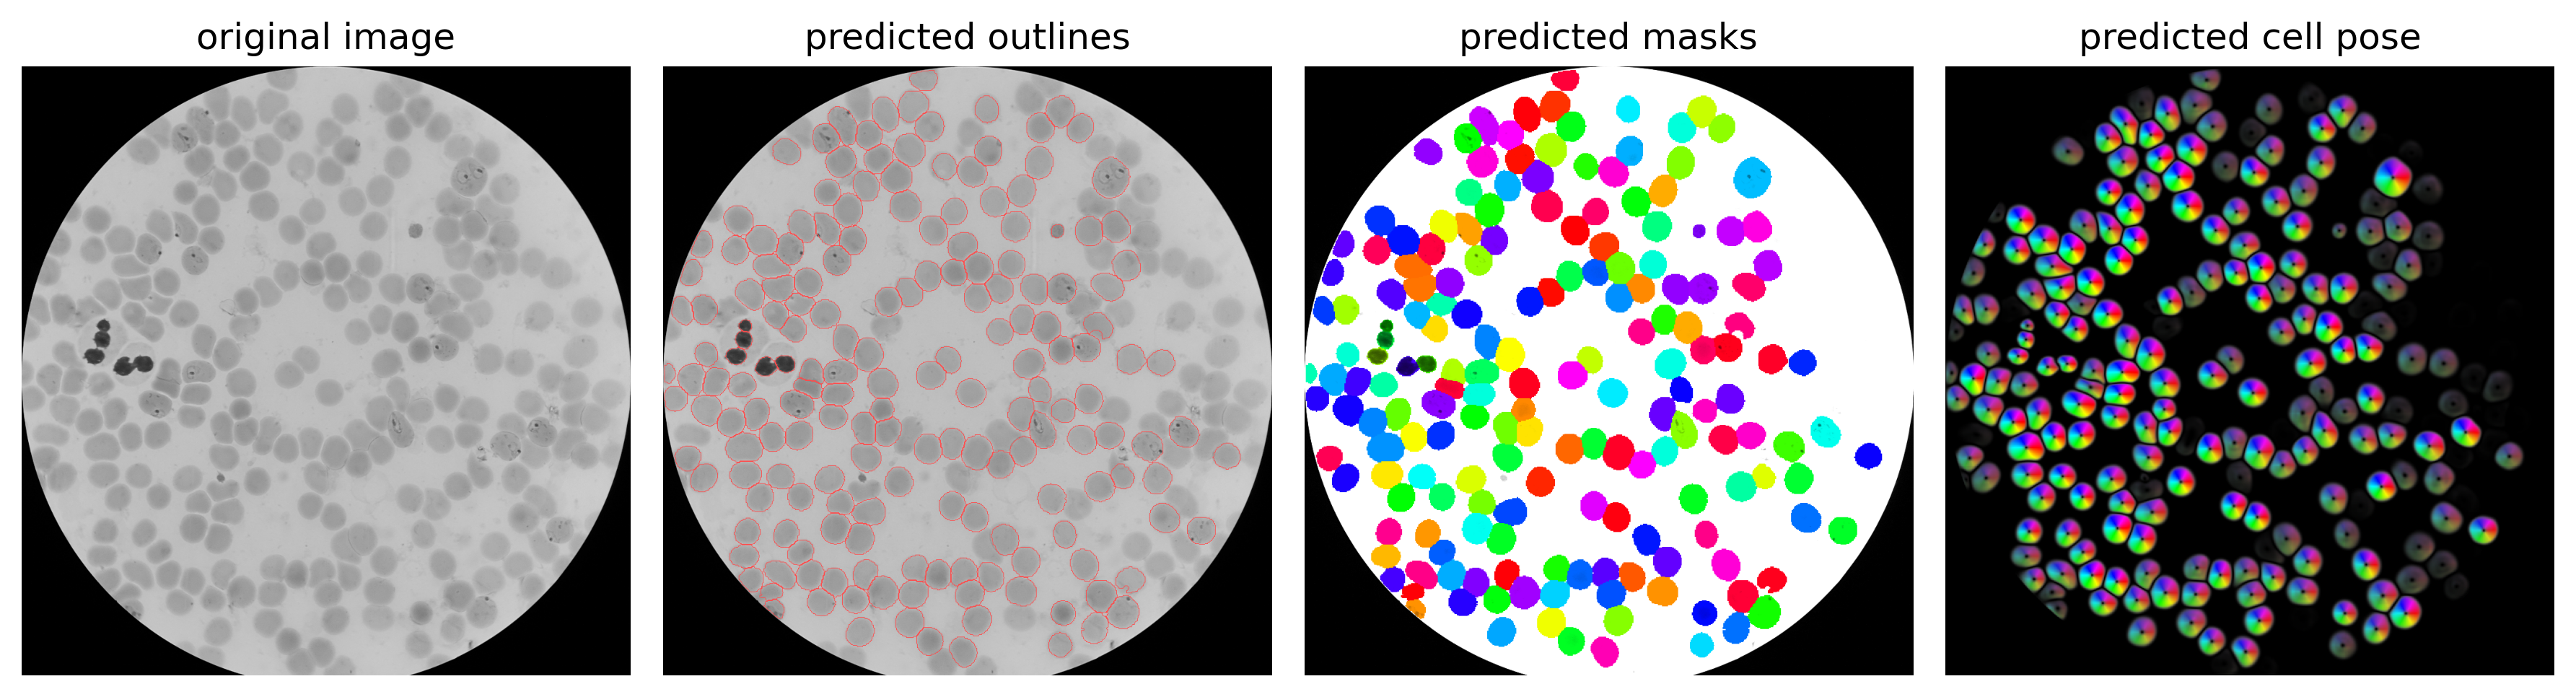

In [36]:
# DISPLAY RESULTS
from cellpose import plot

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()

In [37]:
plt.imshow(masks)

(-0.5, 1023.5, 1023.5, -0.5)

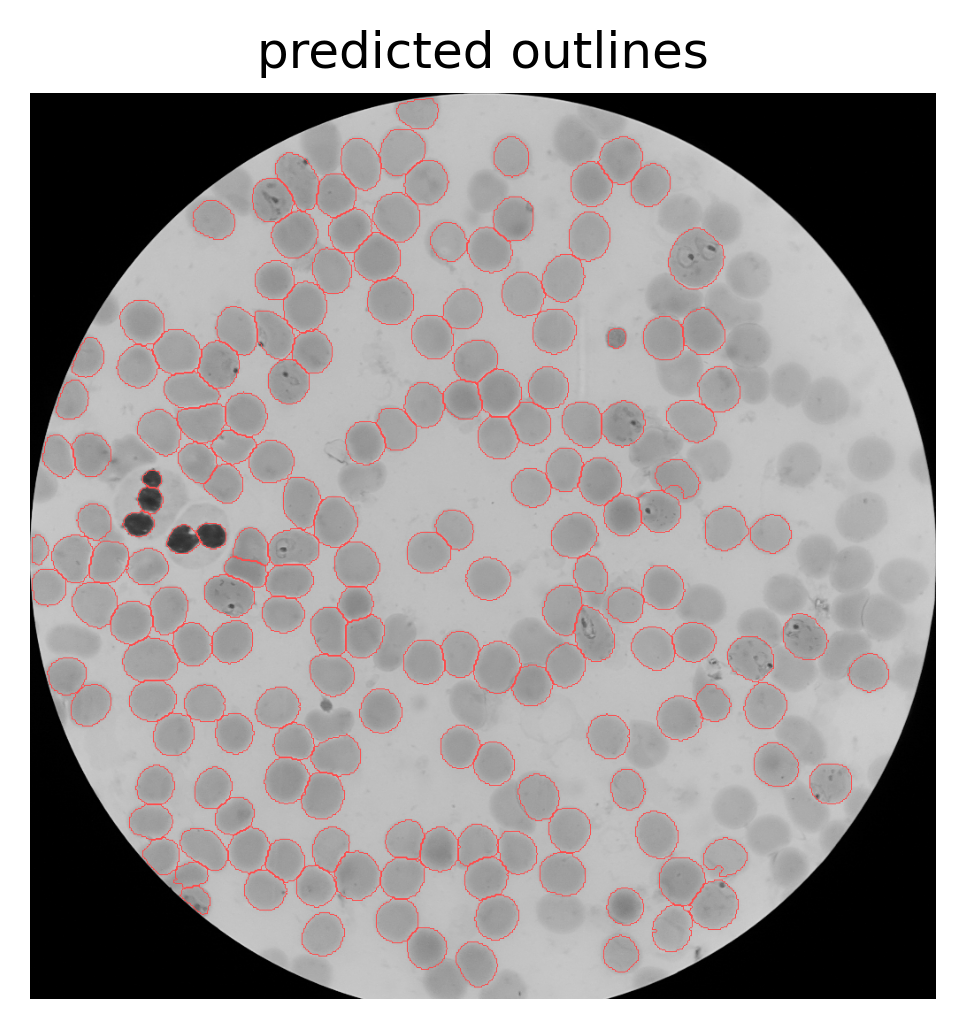

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
outlines = utils.masks_to_outlines(masks_all[-1])
outX, outY = np.nonzero(outlines)
imgout= imgs_red[-1].copy()
imgout[outX, outY] = np.array([255,75,75])
ax.imshow(imgout)
#for o in outpix:
#    ax.plot(o[:,0], o[:,1], color=[1,0,0], lw=1)
ax.set_title('predicted outlines')
ax.axis('off')

# Retrain with NIH Data

In [39]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

https://github.com/MouseLand/cellpose/blob/5cc03de9c2aa342d4b4469ff476ca04541b63414/docs/train.rst

Following the comments of https://github.com/MouseLand/cellpose/issues/211 <br>
I changed line 316 of /usr/local/lib/python3.6/dist-packages/cellpose/models.py to <br>
   def __init__(self, **gpu=True**, pretrained_model=False, torch=True, ...

In [40]:
#Settings
# --check_mkl', action='store_true', help='check if mkl working'

#'--mkldnn', action='store_true', help='for mxnet, force MXNET_SUBGRAPH_BACKEND = "MKLDNN"')

#'--train', action='store_true', help='train network using images in dir')
#'--dir', required=False, help='folder containing data to run or train on')
#  '--mxnet', action='store_true', help='use mxnet')
#  '--img_filter', required=False, default=[], type=str, help='end string for images to run on')
#  '--use_gpu', action='store_true', help='use gpu if mxnet with cuda installed')
#   '--fast_mode', action='store_true', help="make code run faster by turning off 4 network averaging")
#  '--resample', action='store_true', help="run dynamics on full image (slower for images with large diameters)")
# '--no_interp', action='store_true', help='do not interpolate when running dynamics (was default)')
#  '--do_3D', action='store_true',  help='process images as 3D stacks of images (nplanes x nchan x Ly x Lx')
   
# settings for training
#    parser.add_argument('--train_size', action='store_true', help='train size network at end of training')
#    parser.add_argument('--mask_filter', required=False, default='_masks', type=str, help='end string for masks to run on')
#    parser.add_argument('--test_dir', required=False, default=[], type=str, help='folder containing test data (optional)')
#    parser.add_argument('--learning_rate', required=False, default=0.2, type=float, help='learning rate')
#    parser.add_argument('--n_epochs', required=False, default=500, type=int, help='number of epochs')
#    parser.add_argument('--batch_size', required=False, default=8, type=int, help='batch size')
#    parser.add_argument('--residual_on', required=False, default=1, type=int, help='use residual connections')
#    parser.add_argument('--style_on', required=False, default=1, type=int, help='use style vector')
#    parser.add_argument('--concatenation', required=False, dfault=0, type=int, help='concatenate downsampled layers with upsampled layers (off by default which means they are added)')


In [45]:
!python -m cellpose \
--train \
--use_gpu \
--dir ../data/fit_to_circle/train/ \
--test_dir ../data/fit_to_circle/test/ \
--pretrained_model None \
--n_epochs 200

** TORCH CUDA version installed and working. **
>>>> using GPU
>>>> training from scratch
>>>> during training rescaling images to fixed diameter of 30.0 pixels
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
Killed


In [46]:
custom_model_path = '../data/fit_to_circle/train/models/cellpose_residual_on_style_on_concatenation_off_train_2021_04_18_12_27_24.044714'
model = models.CellposeModel(gpu=True, pretrained_model=custom_model_path, torch=False, diam_mean=30.0, net_avg=True, device=None, residual_on=True, style_on=True, concatenation=False)

masks_all = []

for img in imgs_red:
    chan = [0, 0] # for black and white imgs
    #img = io.imread(filename)
    masks, flows, styles = model.eval(img, diameter=50, channels=chan)

    masks_all.append(masks)

# DISPLAY RESULTS

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()

parsing model string to get cellpose options
** TORCH CUDA version installed and working. **
>>>> using GPU
time spent: running network 0.22s; flow+mask computation 0.69
time spent: running network 0.13s; flow+mask computation 0.67
time spent: running network 0.12s; flow+mask computation 0.66
time spent: running network 0.12s; flow+mask computation 0.65


In [41]:
!python -m cellpose \
--train \
--use_gpu \
--dir ../data/fit_to_circle/train/ \
--test_dir ../data/fit_to_circle/test/ \
--pretrained_model cyto \
--learning_rate 0.0002 \
--n_epochs 200

** TORCH CUDA version installed and working. **
>>>> using GPU
>>>> pretrained model /root/.cellpose/models/cytotorch_0 is being used
>>>> during training rescaling images to fixed diameter of 30.0 pixels
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
Killed


parsing model string to get cellpose options
** TORCH CUDA version installed and working. **
>>>> using GPU


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


time spent: running network 0.27s; flow+mask computation 0.82
time spent: running network 0.14s; flow+mask computation 0.76
time spent: running network 0.15s; flow+mask computation 0.79
time spent: running network 0.12s; flow+mask computation 0.70


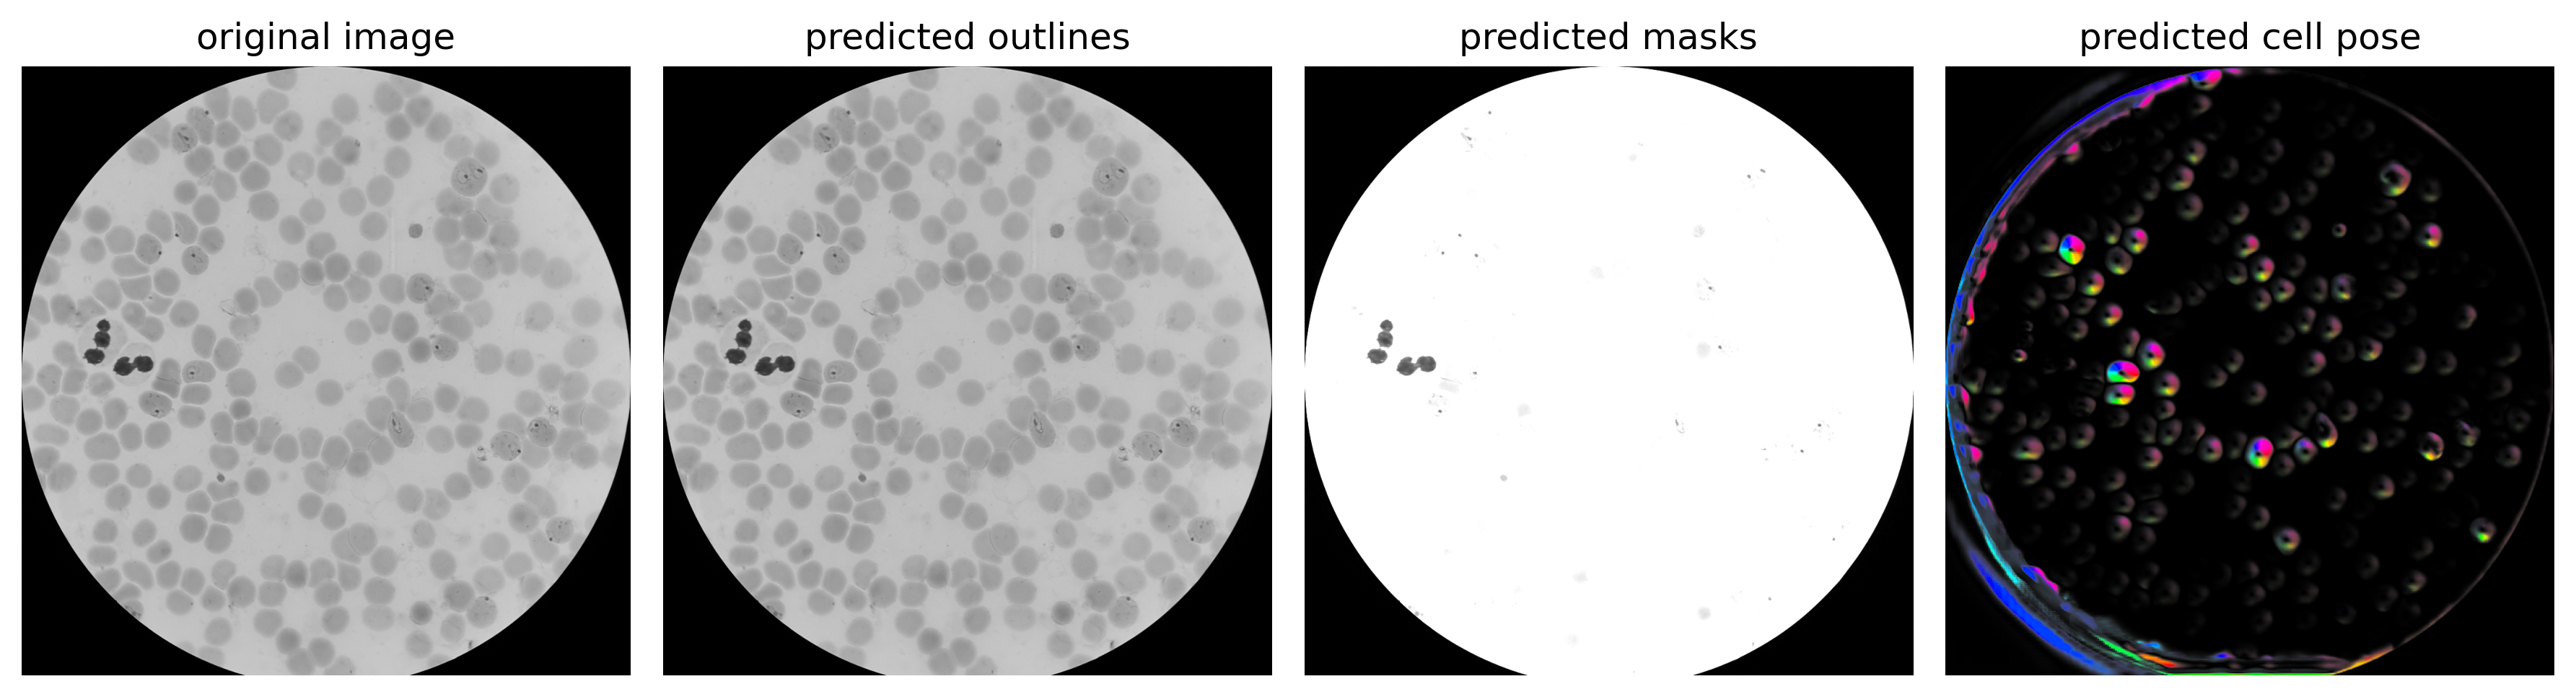

In [42]:
custom_model_path = '/tf/data/fit_to_circle/train/models/cellpose_residual_on_style_on_concatenation_off_train_2021_04_18_13_21_03.782453'
model = models.CellposeModel(gpu=True, pretrained_model=custom_model_path)

masks_all = []

for img in imgs_red:
    chan = [0, 0] # for black and white imgs
    #img = io.imread(filename)
    masks, flows, styles = model.eval(img, diameter=50, channels=chan)

    masks_all.append(masks)

# DISPLAY RESULTS

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()

In [43]:
!python -m cellpose \
--train \
--use_gpu \
--dir ../data/fit_to_circle/train_512/ \
--test_dir ../data/fit_to_circle/test_512/ \
--pretrained_model cyto \
--learning_rate 0.0002 \
--n_epochs 200

** TORCH CUDA version installed and working. **
>>>> using GPU
^C
Traceback (most recent call last):
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/cellpose/__main__.py", line 258, in <module>
    main()
  File "/usr/local/lib/python3.6/dist-packages/cellpose/__main__.py", line 188, in main
    output = io.load_train_test_data(args.dir, test_dir, imf, args.mask_filter, args.unet)
  File "/usr/local/lib/python3.6/dist-packages/cellpose/io.py", line 127, in load_train_test_data
    flows = imread(flow_names[n])
  File "/usr/local/lib/python3.6/dist-packages/cellpose/io.py", line 40, in imread
    img = tifffile.imread(filename)
  File "/usr/local/lib/python3.6/dist-packages/tifffile/tifffile.py", line 721, in imread
    return tif.asarray(**kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tifffile/ti

parsing model string to get cellpose options
** TORCH CUDA version installed and working. **
>>>> using GPU
time spent: running network 0.27s; flow+mask computation 1.68
time spent: running network 0.28s; flow+mask computation 1.78
time spent: running network 0.27s; flow+mask computation 1.66
time spent: running network 0.26s; flow+mask computation 1.63


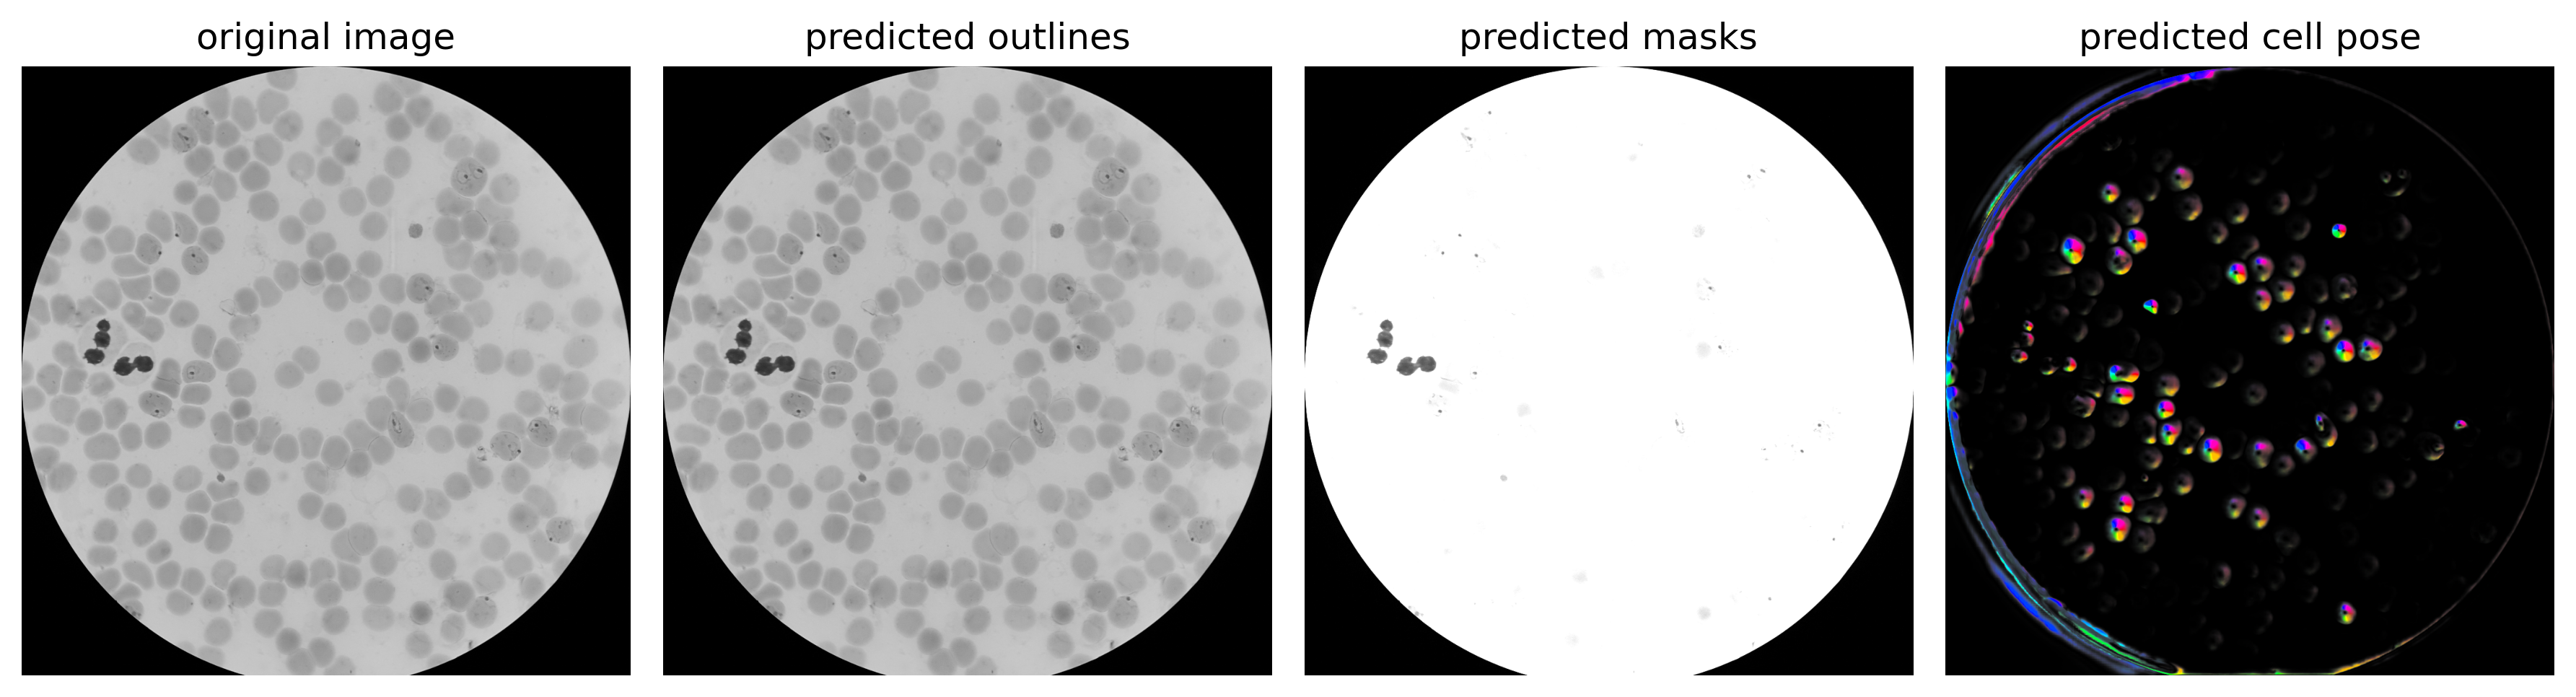

In [141]:
custom_model_path = '../data/fit_to_circle/train_512/models/cellpose_residual_on_style_on_concatenation_off_train_512_2021_04_18_13_44_09.948435'
model = models.CellposeModel(gpu=True, pretrained_model=custom_model_path, torch=False, diam_mean=30.0, net_avg=True, device=None, residual_on=True, style_on=True, concatenation=False)

masks_all = []

for img in imgs_red:
    chan = [0, 0] # for black and white imgs
    #img = io.imread(filename)
    masks, flows, styles = model.eval(img, diameter=30, channels=chan)

    masks_all.append(masks)

# DISPLAY RESULTS

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()